In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import numpy as np
from glob import glob
import tqdm

%matplotlib inline

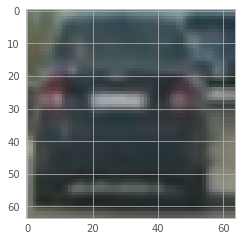

In [3]:
img = mpimage.imread('data/vehicles/vehicles/GTI_MiddleClose/image0000.png')
plt.imshow(img)

In [4]:
subKeys = {
    'vehicles': ['GTI_Far', 'GTI_Left', 'GTI_Right', 'GTI_MiddleClose'],
    'non-vehicles': ['GTI'],
}

In [5]:
paths = []
for mainKey in subKeys.keys():
    for subKey in subKeys[mainKey]:
        basePath = './data/%s/%s/%s/*.png' % (mainKey, mainKey, subKey)
        paths.extend([
            (
                int(path.split('/')[-1].replace('.png', '').replace('image', '')),
                mainKey,
                subKey,
                path,
            )
            for path in glob(basePath)
        ])

In [6]:
paths[0]

(178,
 'non-vehicles',
 'GTI',
 './data/non-vehicles/non-vehicles/GTI/image178.png')

In [7]:
ids = [x[0] for x in paths]
Y = [
    0 if veh == 'non-vehicles' else subKeys['vehicles'].index(gti)
    for (i, veh, gti, path)
    in paths
]
images = [
    mpimage.imread(path)
    for (i, veh, gti, path) in tqdm.tqdm_notebook(paths, unit='path')
]

HBox(children=(IntProgress(value=0, max=6726), HTML(value='')))

IDs are non-unique, so useless.

In [8]:
len(ids), len(set(ids))

(6726, 3901)

Images fit comfortably in memory, however.

In [9]:
d = images[0].dtype
print('%.3g MB' % (sum([x.size for x in images]) * d.alignment / 1024. / 1024.,))

315 MB


In [17]:
from importlib import reload
import vehicleDetection.search_classify
reload(vehicleDetection.search_classify)

<module 'vehicleDetection.search_classify' from '/mnt/wdblue/Dropbox/Projects/Vehicle Detection/vehicleDetection/search_classify.py'>

In [22]:
x = vehicleDetection.search_classify.single_img_features(images[0])
x.size, images[0].size

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(4932, 12288)

In [24]:
X = [
    vehicleDetection.search_classify.single_img_features(image)
    for image in tqdm.tqdm_notebook(images, unit='image')
]

HBox(children=(IntProgress(value=0, max=6726), HTML(value='')))

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [32]:
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

In [26]:
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [28]:
y = np.array(Y).astype('bool')

In [29]:
#rand_state = np.random.randint(0, 100)
rand_state = 4
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state
)

In [33]:
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

Feature vector length: 4932
19.26 Seconds to train SVC...


In [34]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.8826
My SVC predicts:  [False False  True False False False False  True False False]
For these 10 labels:  [False False  True False False False False  True False False]
0.00756 Seconds to predict 10 labels with SVC


In [35]:
img = mpimage.imread('test_images/test1.jpg')
windows = vehicleDetection.lesson_functions.slide_window(img)

In [38]:
bboxes = vehicleDetection.search_classify.search_windows(img, windows, svc, X_scaler)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


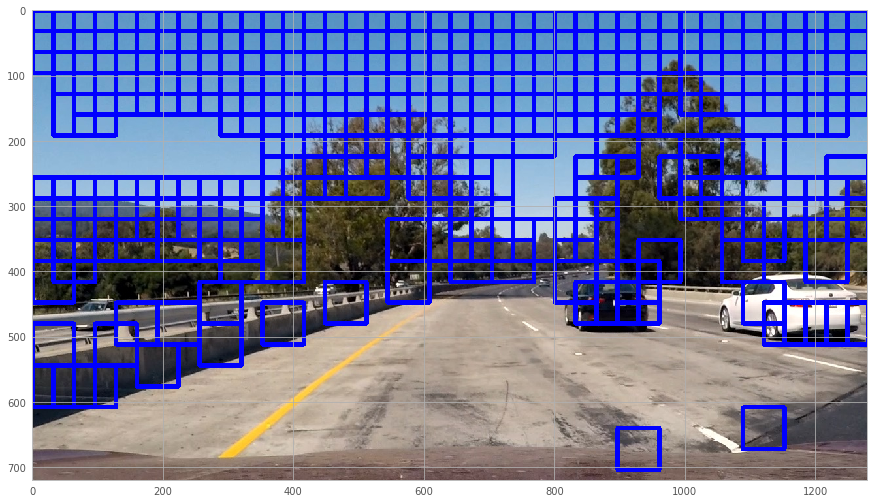

In [40]:
fig, ax = plt.subplots(figsize=(16,9))
ax.imshow(vehicleDetection.lesson_functions.draw_boxes(img, bboxes))